# Sentiment Prediction on IMDB Movie Reviews

 For this project, we will be predicting the sentiment of movie reviews whether they are positive or negative. We will be using the IMDB movie reviews dataset that is conveniently available that is built in into the Keras package. We will also be using LSTM's to read the reviews and make a prediction. 

In [1]:
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM,Embedding,Dense
from keras.models import Sequential

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load the data from Keras

In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data('/tmp/imdb.npz',
                                                      num_words=None, 
                                                      skip_top=0, 
                                                      maxlen=None, 
                                                      start_char=1, #the start of the review will begin with a 1
                                                      oov_char=2, #any characters that are not in the dataset will be assigned 2
                                                      index_from=3) #shift the dictionary by 3

### Data shape

In [3]:
print('X_train has a shape of ' + str(X_train.shape))
print('y_train has a shape of ' + str(y_train.shape))
print('X_test has a shape of ' + str(X_test.shape))
print('y_test has a shape of ' + str(y_test.shape))

X_train has a shape of (25000,)
y_train has a shape of (25000,)
X_test has a shape of (25000,)
y_test has a shape of (25000,)


This means that our training and testing dataset are both of equal shape and they both have 25000 reviews which is a decent size dataset.

### Looking at the Data

As we can see below the data has been encoded so, we need to use the dictionary to decode it into human readable form.

In [4]:
for i in range(10):
    print(X_train[i][:15])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4]
[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4]
[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5974, 54, 61]
[1, 4, 18609, 16085, 33, 2804, 4, 2040, 432, 111, 153, 103, 4, 1494, 13]
[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 14, 20, 56, 33, 2401]
[1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 7982, 1051, 43222, 32, 85]
[1, 6740, 365, 1234, 5, 1156, 354, 11, 14, 5327, 6638, 7, 1016, 10626, 5940]
[1, 4, 14906, 716, 4, 65, 7, 4, 689, 4367, 6308, 2343, 4804, 28674, 84206]
[1, 43, 188, 46, 5, 566, 264, 51, 6, 530, 664, 14, 9, 1713, 81]
[1, 14, 20, 47, 111, 439, 3445, 19, 12, 15, 166, 12, 216, 125, 40]


As we can see all of the reviews starts with the number 1. This is because the number 1 symbolizes the start of the review as we decided earlier.

### Word Index

In [5]:
idx = imdb.get_word_index()

In [6]:
print('There are ' + str(len(idx)) + ' words in the dictionary.')

There are 88584 words in the dictionary.


### Index Samples

In [7]:
{k: idx[k] for k in list(idx)[:10]}

{"''troubled''": 79833,
 'beliveable': 79412,
 "bernhard's": 37497,
 "forbes's": 59829,
 'greebling': 65219,
 'harmonic': 32201,
 'jarjar': 55886,
 'kassie': 79885,
 'sn': 61199,
 'sport': 4106}

### Swap Keys With Index and Move 3 Places

Currently, our dictionary has the words as keys. We will swap them out so that we can convert our numeric data into something human readable. 

In [8]:
rev_idx = {v + 3:k for k,v in idx.items()}

In [9]:
{k: rev_idx[k] for k in list(rev_idx)[:10]}

{4: 'the',
 5: 'and',
 6: 'a',
 7: 'of',
 8: 'to',
 9: 'is',
 10: 'br',
 11: 'in',
 12: 'it',
 13: 'i'}

In addition, we also have to add our padding character, starting character, special characters

In [10]:
rev_idx[0] = 'padding_char'
rev_idx[1] = 'start_char'
rev_idx[2] = 'oov_char'
rev_idx[3] = 'unk_char'

### Converting Data Into Human Readable Text

<i>**Example 1**</i>

In [11]:
' '.join([rev_idx[word] for word in X_train[0]])

"start_char this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and

<i>**Example 2**</i>

In [12]:
' '.join([rev_idx[word] for word in X_train[1]])

"start_char big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their stomachs sickening that men actually wore them and the music is just synthesiser trash that plays over and over again in almost every scene there is trashy music boobs and paramedics taking away bodies and the gym still doesn't close for bereavement all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back the

<i>**Example 3**</i>

In [13]:
' '.join([rev_idx[word] for word in X_train[2]])

"start_char this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had earnt working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how embarrasing this is to watch save yourself an hour a bit of your life"

As you can see in the texts above, they all started with "start_char". In the datasets, we can observe that there are no punctuations and all the text is in lowercase. This was done in order to reduce the size of the dictionary.

### Observation sizes

In [14]:
print('Example 1 has a length of ' + str(len(X_train[0])) + ' words.')
print('Example 2 has a length of ' + str(len(X_train[1])) + ' words.')
print('Example 3 has a length of ' + str(len(X_train[2])) + ' words.')

Example 1 has a length of 218 words.
Example 2 has a length of 189 words.
Example 3 has a length of 141 words.


Text is considered unstructured data so, each observation can be of varying sizes. We have to make each one of the same size because the model only accepts data that is of a specific size.

### Padding Sequences

To address the concern mentioned above, we can pad the data for it to increase its size or we can also reduce its size by truncating it in the beggining or at the end. For this exercise we will use 100 words and cut the beginning. 

In [15]:
maxlen = 100

X_train_pad = pad_sequences(X_train,maxlen=maxlen)
X_test_pad = pad_sequences(X_test,maxlen=maxlen)

### Data Shapes

In [16]:
print('X_train has a shape of ' + str(X_train.shape))

X_train has a shape of (25000,)


In [17]:
print('X_train_pad has a shape of ' + str(X_train_pad.shape))

X_train_pad has a shape of (25000, 100)


As we can see above X_train_pad now has 100 columns because of our padding. The number of columns are now in uniform.

### Observing the Difference

**Normal Data**

In [18]:
' '.join([rev_idx[word] for word in X_train[0]])

"start_char this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and

**Padded Data**

In [19]:
' '.join([rev_idx[word] for word in X_train_pad[0]])

"cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

As we can see above the length of the padded data is shorter by cutting the beginning out.

### Get Max Features

We need to get the max features for the shape of the embedding.

In [20]:
max_features = max([max(x) for x in X_train_pad] + 
                   [max(x) for x in X_test_pad]) + 1
max_features

88587

### Create Model

In [21]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Train Model

In [23]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=3)

Epoch 1/3
25000/25000 [==============================] - 129s 5ms/step - loss: 0.2044 - acc: 0.9211
Epoch 2/3
25000/25000 [==============================] - 130s 5ms/step - loss: 0.1168 - acc: 0.9580
Epoch 3/3
25000/25000 [==============================] - 129s 5ms/step - loss: 0.0735 - acc: 0.9750


### Model Accuracy

In [24]:
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 28s 1ms/step
Test score: 0.695197280114
Test accuracy: 0.82504


As you can see our model did okay, it is pretty decent. However, we want to further improve it.

## Improving the model

To further improve the model we are going to try a variety of techniques but first we have to look closer into the data.

### Length of Reviews

In [25]:
lengths = []
for i in range(len(X_train)):
    lengths.append(len(X_train[i]))

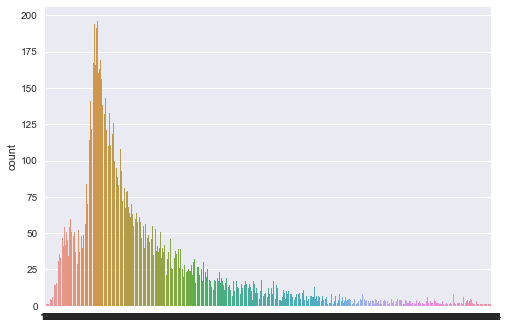

In [26]:
import seaborn as sns
sns.countplot(lengths)

As we can see, there are a decent amound of reviews that pass 100. So, we will extend the padding to 125 since the dataset is not that big anyway. 

### Increasing the length of Reviews

In [27]:
X_train_pad_more = pad_sequences(X_train,maxlen=175)
X_test_pad_more = pad_sequences(X_test,maxlen=175)

In [28]:
X_train_pad_more.shape

(25000, 175)

### Word Frequency

Another thing that we want to address is the frequency of the words we have used. For sure some words just add noise to our data.

In [29]:
flat_list = []
for sublist in X_train:
    for item in sublist:
        flat_list.append(item)

In [30]:
from collections import Counter
word_freq = Counter(flat_list)

(0, 100)

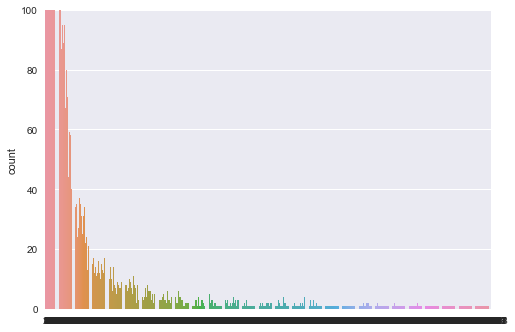

In [31]:
lm  = sns.countplot(list(word_freq.values()))
lm.set_ylim(0,100)

### Remove Words that are low in frequency

In [32]:
X_train_pad_more[X_train_pad_more>5000] = 3
X_test_pad_more[X_test_pad_more>5000] = 3

In [33]:
print('Words Removed: ' + str(pd.Series(sum(X_train_pad_more==3)/len(X_train_pad_more)).mean()) )

Words Removed: 0.07849622857142853


We only removed about 8 percent of the words who are most likely just noise.

**Sample 1**

In [34]:
' '.join([rev_idx[word] for word in X_train_pad_more[0]])

"scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for unk_char and would recommend it to everyone to watch and the fly unk_char was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also unk_char to the two little unk_char that played the unk_char of norman and paul they were just brilliant children are often left out of the unk_char list i think because the stars that play them all grown up are such a big unk_char for the whole film but these children are amazing and should be unk_char for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was unk_char with us all"

As you can see above, there are more "unk_char" because we replaced the words that are not very frequent into them. We did this to reduce the noise in the dataset.

### Final Model

In [35]:
from keras import backend as K
K.clear_session()

In [36]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [37]:
model.fit(X_train_pad_more, y_train,
          batch_size=32,
          epochs=3)

Epoch 1/3
25000/25000 [==============================] - 220s 9ms/step - loss: 0.4784 - acc: 0.7694
Epoch 2/3
25000/25000 [==============================] - 210s 8ms/step - loss: 0.3695 - acc: 0.8424
Epoch 3/3
25000/25000 [==============================] - 210s 8ms/step - loss: 0.3114 - acc: 0.8712


In [38]:
score, acc = model.evaluate(X_test_pad_more, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 46s 2ms/step
Test score: 0.348809408703
Test accuracy: 0.85356


In [39]:
from keras.models import load_model
model.save('model_imdb.h5') 
model = load_model('model_imdb.h5')

The initial model was able to get an accuracy of 82.22%, because of the improvements we have made we were able to increase it by 3% to an accuracy of 85%

### Sample Predictions

In [67]:
import numpy as np
def print_sample(data,data_pad,index,rev_idx):
    print()
    print(' '.join([rev_idx[word] for word in data[index]]))
    print()
    print('PREDICTION:' + str(np.ravel(model.predict(data_pad[index].reshape(1,175)))) +'% Positive')
    
    if (y_train[index]==1):
        output = 'Positive'
    else:
        output = 'Negative'
    print('ACTUAL: ' + str(output))
    print()
    return None

<i>**Example 1**</i>

In [71]:
print_sample(X_test_pad,X_test_pad_more,11148,rev_idx)


to be the next best thing since x files but as always nothing will ever take down that show in my opinion i am telling you it's scary and then suspenseful and then mellow towards the end you have miles as a love puppy with a weird pet that is a new species you have two people on the run from authorities and a killer tsunami about to strike wow and did i mention miles pet is a potential killer well the rest of his species is surface is a brilliant show with spins and twists that delivers it all

PREDICTION:[ 0.94032401]% Positive
ACTUAL: Positive



<i>**Example 2**</i>

In [70]:
print_sample(X_test_pad,X_test_pad_more,100,rev_idx)


you actually want to die however delivers considerably more br br rather than focus on bare flesh and gore though there is a little of each no sex however the flick focuses on delivering impending dread mounting tension amidst a lovely scenic backdrop these feelings are further heightened by a cast of realistically likable characters and antagonists that are more amoral than cardboard definitions of evil oh yeah george kennedy is here too and when is that not a good thing br br if you liked wrong turn then watch this to see where much of its' methodology came from

PREDICTION:[ 0.03893274]% Positive
ACTUAL: Negative

